In [154]:
"""
Author: Zaw
Predicting the gain of smooth pursuit eye movement 
"""

import numpy as np
import pandas as pd
import math 
import time
import os
import sys
import warnings
warnings.simplefilter(action='ignore')
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from hyperopt import fmin,tpe,hp,STATUS_OK, Trials
import pickle
from hyperopt import hp
from sklearn.model_selection import GridSearchCV
import shap
#start = time.time()
import pickle

### Reading dataset

In [155]:
#data path
path = os.getcwd()
dirname = os.path.dirname(path)
data_file = 'data/data.csv'
data_path = os.path.join(dirname,data_file)

In [156]:
# load dataset
data = pd.read_csv(data_path)

In [157]:
data.head()

,Label,Patient,A1_1Deg,A1_1Deg_err,B1_1Deg,B1_1Deg_err,C1_1Deg,C1_1Deg_err,1_Deg_ResSoS_1,1Deg_AdjR2_1,...,8_Deg_ResSoS_1,8Deg_AdjR2_1,A2_8Deg,A2_8Deg_err,B2_8Deg,B2_8Deg_err,C2_8Deg,C2_8Deg_err,8_Deg_ResSoS_2,8Deg_AdjR2_2
0,Not_Parkinson's,PD001,10.388190,0.006132,0.049329,0.000006,0.011989,0.000337,8928.709194,0.990598,...,6698.838281,0.951413,10.273124,0.044206,0.386347,0.000384,0.037356,0.002439,6809.455800,0.939095
1,Not_Parkinson's,PD002,10.429055,0.006929,0.049478,0.000007,0.002837,0.000379,11388.604704,0.988092,...,4769.901822,0.967360,11.482500,0.049154,0.395412,0.000380,-0.002486,0.002419,8383.481840,0.939586
2,Not_Parkinson's,PD003,10.097088,0.005091,0.049368,0.000006,0.005707,0.000287,6140.292312,0.993141,...,3488.747176,0.968709,10.084338,0.019838,0.394595,0.000174,-0.035466,0.001106,1349.962240,0.987259
3,Not_Parkinson's,PD004,10.482881,0.022179,0.049585,0.000023,0.016056,0.001212,117748.979710,0.879372,...,10972.045844,0.920137,11.493414,0.048867,0.401386,0.000377,-0.042463,0.002395,8242.136178,0.940370
4,Not_Parkinson's,PD005,10.181273,0.008833,0.049368,0.000010,0.001569,0.000494,18447.340517,0.979692,...,18268.960666,0.809586,10.370348,0.036121,0.395392,0.000308,-0.030769,0.001960,4485.300264,0.960035


### Add calculated gain

In [158]:
OneDegGain = np.array([
                    0.912073221615219,
                    0.913615300167855,
                    0.946453363089275,
                    0.930324124079886,
                    1.02416020436668,
                    0.860239837548296,
                    0.964705222165739,
                    0.926124390992111,
                    0.968894500894799,
                    0.971483673217362,
                    0.944374366569671,
                    0.933778991410942,
                    0.890761283462127,

                    1.01702677636733,
                    1.01132254481336,
                    0.860332024178068,
                    0.898244125409108,
                    0.79226520992959,
                    0.86763213956782,

                    1.04294995675946,
                    0.954852019394754,
                    0.83139435252038,
                    0.969027023632338,
                    0.819025317130086,
                    0.887491,
                    0.827558754578517,
                    0.882328237761475,
                    0.888806663106777  
                ])

TowDegGain  = np.array([
                    0.88795482315922,
                    0.85125583179904,
                    0.90557113971074,
                    0.839308531914961,
                    0.944624517823793,
                    0.936063494064383,
                    0.919761689613053,
                    0.857703024614198,
                    0.973218178159532,
                    0.936570806828469,
                    0.955653090017782,
                    0.943385867113339,
                    1.0186446733178,

                    0.957719524164782,
                    0.847863270306327,
                    0.762131387734656,
                    0.71762368625312,
                    0.699023420441996,
                    0.860669705999712,
                    
                    0.882514198813699,
                    0.900439093391636,
                    0.852845556682743,
                    0.662387043701962,
                    1.02691189892667,
                    0.929980500477329,
                    0.795054974778894,
                    0.915409616170048,
                    0.936562782215738
])

FourDegGain = np.array([
                    0.842657428787201,
                    0.927453824629543,
                    0.86099798858682,
                    0.826284460023473,
                    0.907866303422781,
                    0.886319852935139,
                    0.879363613650586,
                    0.945246226705543,
                    0.865730996104868,
                    0.949044695789533,
                    0.927054434038832,
                    0.907460103985577,
                    0.768451296309936,

                    0.670432552659765,
                    0.82906287014668,
                    0.792533491957787,
                    0.564497325152498,
                    0.566934462769341,
                    0.745104906289544,

                    0.863969643770036,
                    0.810695262798471,
                    0.665919934919724,
                    0.531701684005337,
                    0.804825842988611,
                    0.849537457619557,
                    0.843883703581647,
                    0.696788329556185,
                    0.878210689819177
])

SixDegGain = np.array([
                    0.795081992082097,
                    0.810824945533769,
                    0.776092810922058,
                    0.667632972614243,
                    0.875563679555973,
                    0.832291613200056,
                    0.896167465701247,
                    0.838934215329476,
                    0.91951999621913,
                    0.931875303042642,
                    0.881653294348028,
                    0.866711106710116,
                    0.950478365248271,

                    0.876172814217401,
                    0.793820437144166,
                    0.674619968989113,
                    0.508275303789709,
                    0.454613572040806,
                    0.761053355757645,

                    0.708138512300574,
                    0.875686044405767,
                    0.62197374329538,
                    0.682965128345167,
                    0.745383783235028,
                    0.904919560234923,
                    0.97349927736433,
                    0.790221320229067,
                    0.96896278814672
])

EightDegGain = np.array([
                    0.738482610210994,
                    0.986636423035039,
                    0.745501747649165,
                    0.757990700258398,
                    0.909797906001487,
                    0.781053010159343,
                    0.85865978762173,
                    0.859516710190982,
                    0.885411917285177,
                    0.828367438419201,
                    0.911980104842521,
                    0.863014297113752,
                    0.708399551278433,

                    0.673980441334396,
                    0.795542507563886,
                    0.795542507563886,
                    0.570216915379213,
                    0.470689666436208,
                    0.816745486005565,

                    0.730673411270229,
                    0.84023883503095,
                    0.634293750883143,
                    0.529398709071705,
                    0.750469831451345,
                    0.748589580457503,
                    0.881237281923916,
                    0.750773552799239,
                    0.972603229161408
])

In [159]:
# Array to dataframe
# gain = pd.DataFrame({'OneDegGain':OneDegGain,'TowDegGain':TowDegGain,'FourDegGain':FourDegGain,
#                     'SixDegGain':SixDegGain,'EightDegGain':EightDegGain})
gain = pd.DataFrame({
                     'OneDegGain':OneDegGain
})

In [161]:
# Standardization
#sc = StandardScaler()
#data_input = pd.DataFrame(sc.fit_transform(data.iloc[:,2:]),index=data.iloc[:,2:].index, columns= data.iloc[:,2:].columns)
# Concat with gain
data_gain = pd.concat([data.iloc[:,2:],gain],axis=1) # drop patient and Label column

#data_gain = gain_df

# # Features and labels
# x = data_input.iloc[:,2:]
# y = data.iloc[:,0]

# ## Convert the categorical variables to number
# LabelEncoder_gender = LabelEncoder()
# y = LabelEncoder_gender.fit_transform(y)

# # convert array to series 
# y = pd.Series(y,name='Label')
# df = pd.concat([x,y],axis=1)

# ## Convert the categorical variables to number
# LabelEncoder_gender = LabelEncoder()
# data_gain['Label'] = LabelEncoder_gender.fit_transform(data_gain['Label'])


# # drop patien column
# data_gain = data_gain.drop(['Patient'],axis=1)


In [162]:
#Check NaN
data_gain.isnull().values.any()

True

In [164]:
# Filling nan with mean values 
for col in data_gain:
    data_gain[col].fillna(data_gain[col].mean(),inplace=True)

In [165]:
#Check NaN again
data_gain.isnull().values.any()

False

In [166]:
data_gain.shape

(29, 81)

In [139]:
# # Remove features with low variance (thrshold <= 0.05)
# df_var = data_gain.var()
# df_feat = list(df_var[df_var <= 0.05].index)
# data_gain.drop(columns=df_feat, inplace=True)

In [517]:
# Remove features with correlation(threshold > 0.95)
# corr_matrix = data_gain.corr().abs()
# mask = np.triu(np.ones_like(corr_matrix,dtype=bool))
# tri_df = corr_matrix.mask(mask)
# to_drop = [c for c in tri_df.columns if any(tri_df[c] > 0.95)]
# data = data_gain.drop(to_drop,axis=1)

In [167]:
# Parameters
space = {'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
          'gamma': hp.uniform('gamma', 0, 0.2),
          'min_child_weight': hp.choice('min_child_weight', range(1, 6)),
          'subsample': hp.uniform('subsample', 0.7, 1.0),
          'colsample_bytree': hp.uniform('colsample_bytree', 0.7, 1.0),
          'max_depth': hp.choice('max_depth', range(3, 10)),
          'n_estimators': hp.choice('n_estimators', [50, 100, 200, 300, 400, 500, 1000])}
min_child_weight = range(1, 6)
max_depth = range(3, 10)
n_estimators= [100, 200, 300, 400, 500, 1000, 1500, 2000]

In [519]:
# # data set preparation
# train , test = train_test_split(data,train_size = 0.8,shuffle=True,random_state = 3)
# #alidate , test = train_test_split(rest, train_size = 0.5, shuffle=True,random_state = 3)

# # training set
# data_tra_x = train.drop(['SixDegGain'],axis=1)
# data_tra_y = train['SixDegGain']

# # # validation set
# # data_val_x = validate.drop(['OneDegGain'],axis=1)
# # data_val_y = validate['OneDegGain']

# # test set
# data_tes_x = test.drop(['SixDegGain'],axis=1)
# data_tes_y = test['SixDegGain']

In [173]:
x = data_gain.drop(['OneDegGain'],axis=1)
y = data_gain['OneDegGain']
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state= 0)

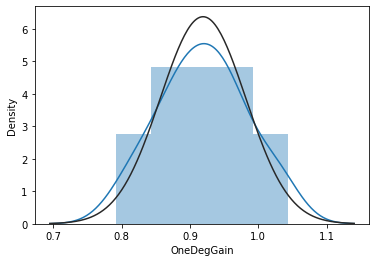

In [174]:
from scipy.stats import norm
from scipy import stats
import seaborn as sns
sns.distplot(data_gain['OneDegGain'],fit=norm)
plt.show()

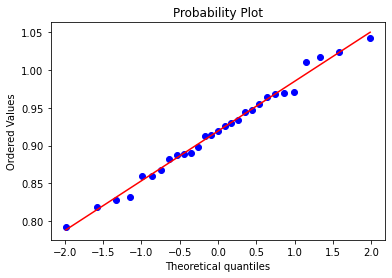

In [175]:
res = stats.probplot(data_gain['OneDegGain'],plot=plt)

In [176]:
# Define a objective function
def hyperparameter_tuning(params):
    model = XGBRegressor(**params,n_jobs=6,seed=1,random_state=1)
    model.fit(X_train,y_train)
    tra_preds = model.predict(X_train)
    loss = mean_squared_error(y_train,tra_preds,squared=False)
    return {'loss': loss,'status':STATUS_OK}
# Initialize trials object
trials = Trials()

# Fine tune the model
best_results = fmin(
    fn=hyperparameter_tuning,
    space = space,
    algo=tpe.suggest,
    max_evals= 50,
    trials=trials
)

100%|██████████| 50/50 [00:17<00:00,  2.88trial/s, best loss: 0.006310585998063181]


In [177]:
best_parameters = dict(best_results)

In [178]:
#save the parameters with lc
file_path = dirname+"/hyperparameters/xgb_reg_one_.pkl"
pickle.dump(best_parameters, open(file_path,'wb'))

In [179]:
#load best parameters
file_path = dirname+"/hyperparameters/xgb_reg_one_.pkl"
best_parameters_one= pickle.load(open(file_path,'rb'))

In [180]:
# best model single run
best_model = XGBRegressor(  n_estimators=n_estimators[best_parameters_one['n_estimators']], 
                            max_depth=max_depth[best_parameters_one['max_depth']],
                            min_child_weight=min_child_weight[best_parameters_one['min_child_weight']],
                            learning_rate=best_parameters_one['learning_rate'],
                            gamma=best_parameters_one['gamma'],
                            subsample=best_parameters_one['subsample'],
                            colsample_bytree=best_parameters_one['colsample_bytree'],
                            n_jobs=6, random_state=1, seed=1)

In [181]:
# Fit
best_model.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1,
             colsample_bytree=0.7387314460329695, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             gamma=0.0002723435887249724, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1963723457714725, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=9, max_leaves=0, min_child_weight=5,
             missing=nan, monotone_constraints='()', n_estimators=1500,
             n_jobs=6, num_parallel_tree=1, predictor='auto', random_state=1,
             reg_alpha=0, reg_lambda=1, ...)

In [187]:
#  training error
tra_pred = best_model.predict(X_train)
# errors = abs(tra_pred-y_train)
# # Calculate mean absolute percentage error (MAPE)
# mape = 100 * (errors / y_train)

# # Calculate and display accuracy
# accuracy = 100 - np.mean(mape)
tra_results = ['tra',mean_squared_error(y_train,tra_pred,squared=False),
              mean_squared_error(y_train,tra_pred,squared=True),
              mean_absolute_error(y_train,tra_pred),r2_score(y_train,tra_pred)
               ]

# # validation error
# val_pred = best_model.predict(data_val_x)
# val_results = ['val',mean_squared_error(data_val_y,val_pred),mean_squared_error(data_val_y,val_pred,squared=False),
#             mean_absolute_error(data_val_y,val_pred),
#             r2_score(data_val_y,val_pred)]
# testing error
tes_pred = best_model.predict(X_test)
# errors = abs(tes_pred-y_test)
# # Calculate mean absolute percentage error (MAPE)
# mape = 100 * (errors / y_test)

# # Calculate and display accuracy
# accuracy = 100 - np.mean(mape)
tes_results = ['tes',mean_squared_error(y_test,tes_pred,squared=False),
              mean_squared_error(y_test,tes_pred,squared=True),
              mean_absolute_error(y_test,tes_pred),r2_score(y_test,tes_pred)
              ]


all_set = tra_results,tes_results


all_set_df = pd.DataFrame(all_set,columns=['set','rmse','mse','mae','r2'])

In [189]:
all_set_df

,set,rmse,mse,mae,r2
0,tra,0.006311,0.000040,0.003788,0.989019
1,tes,0.035806,0.001282,0.032831,0.745153


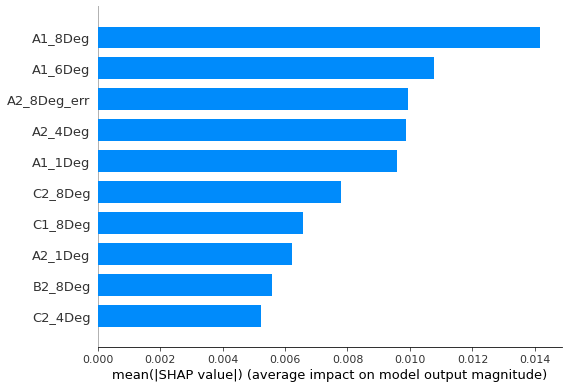

In [190]:
# classifier = xgb.XGBClassifier()
# classifier.fit(x_train,y_train)
# print the JS visualization code to the notebook
shap.initjs()
explainer = shap.Explainer(best_model)
shap_values = explainer(X_test)
#shap.plots.bar(shap_values, max_display= 10,show=False,plot_type='bar')
shap.summary_plot(shap_values, X_test,max_display=10,plot_type='bar')
#plt.savefig("shap_no_gain.png", format="png", dpi=300)


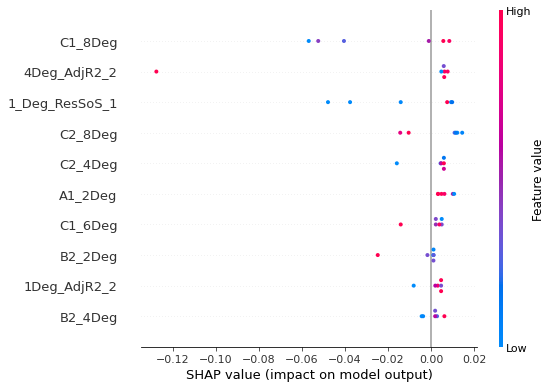

In [44]:
shap.summary_plot(shap_values, data_tes_x,max_display=10,show=False)

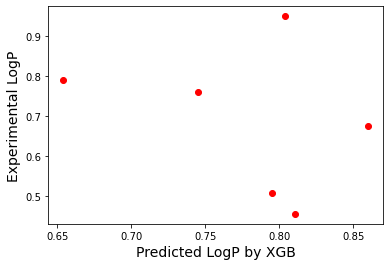

In [35]:
# # best_model.fit(data_tra_x,data_tra_y)
# tes_pred = best_model.predict(data_tes_x)

plt.scatter(predictions,data_tes_y,c='r',alpha=1)
plt.xlabel('Predicted LogP by XGB',fontsize = 14)
plt.ylabel('Experimental LogP',fontsize = 14)
#plt.savefig(dirname+"/p_chem/results/xgb_vs.png", format='png', dpi=600)# plt.savefig("svm.png", format='png', dpi=600)
plt.show()

In [546]:
from sklearn.ensemble import RandomForestRegressor
model = LinearRegression()
model.fit(X_train,y_train)
#predictions = model.predict(data_tes_x)
#X_train, X_test, y_train, y_test 

LinearRegression()

In [ ]:
predictions

In [544]:
r2= r2_score(X_test, y_test)
print('R2 score for rf: ',r2)

ValueError: y_true and y_pred have different number of output (80!=1)

In [499]:
y_pred = model.predict(X_test)
rmse = float(format(np.sqrt(mean_squared_error(y_test, y_pred)), '.3f'))
print("\nRMSE for XGBR: ",rmse)


RMSE for XGBR:  0.045


In [500]:
r2 = r2_score(y_test, y_pred)
print('R2 score for xgbr: ',r2)

R2 score for xgbr:  -0.3314374066104


In [502]:
r2 = r2_score(y_test, y_pred)
print('R2 score for rf: ',r2)

R2 score for rf:  -0.3314374066104


In [497]:
y_pred = model.predict(X_test)
rmse = float(format(np.sqrt(mean_squared_error(y_test, y_pred)), '.3f'))
print("\nRMSE for random forest: ",rmse)


RMSE for random forest:  0.042


In [495]:
y_pred = model.predict(X_test)
rmse = float(format(np.sqrt(mean_squared_error(y_test, y_pred)), '.3f'))
print("\nRMSE for SVR: ",rmse)



RMSE for SVR:  0.04


In [491]:
r_squared = model.score(x,y)
print(r_squared)

0.7529432259450443


In [489]:
RMSLE = model.score(data_tes_y, predictions) 
print("The score is %.5f" % RMSLE )

ValueError: Expected 2D array, got 1D array instead:
array=[0.7610534  0.45461357 0.9504784  0.79022133 0.67462    0.50827533].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [480]:
data_tes_y

18    0.761053
17    0.454614
12    0.950478
26    0.790221
15    0.674620
16    0.508275
Name: SixDegGain, dtype: float64

In [479]:
predictions 

array([0.70325743, 1.40053525, 0.93309679, 0.9824351 , 0.92837175,
       0.80200185])

In [412]:
type(predictions)

pandas.core.series.Series

In [406]:
yy_true = [1, 2, 3]
yy_pred = [3, 2, 1]
RMSLE = r2_score(yy_true,yy_pred) 
print("The score is %.5f" % RMSLE)

The score is -3.00000


In [262]:
x = data_gain.drop(['SixDegGain'],axis=1)
y = data_gain['SixDegGain']

In [263]:
all_run = []
#for split in range(30):
    #cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=split)
kfold = KFold(n_splits=5, shuffle=True,random_state=4)
scores = cross_val_score(model,x,y,scoring='r2', cv=kfold)
scores
# result = [[split,scores.mean()]]
# all_run += result
# #print(all_run)
# all_run_df = pd.DataFrame(all_run,columns=['split','acc'])
# print("XGBoost based model accuracy score: {0:0.4f}".format(all_run_df['acc'].mean()))

array([ -0.88715241,   0.09157291,  -1.7178955 , -30.75758492,
       -78.43404558])

In [264]:
predictions

array([0.85969849, 0.79580121, 0.80054567, 0.77005636, 0.77191537,
       0.79433879])

In [265]:
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state= 42)

In [266]:
from sklearn.linear_model import LinearRegression
from sklearn import svm
predict_reg = svm.SVR()
predict_reg.fit(X_train, y_train)

SVR()

In [267]:
y_pred = predict_reg.predict(X_test)

In [268]:
#y_test = y_test.values.reshape(1,)
pmsh_pf = pd.DataFrame({'Actual':y_test.values.flatten(), 'Predict': y_pred.flatten()})
pmsh_pf

,Actual,Predict
0,0.968963,0.724933
1,0.508275,0.739804
2,0.950478,0.783062
3,0.682965,0.740028
4,0.919520,0.774252
5,0.931875,0.735257


In [259]:
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print("R^2 Score :", r2_score(y_test, y_pred))

Mean Absolute Error: 0.173654157803438
Mean Squared Error: 0.03403369826797902
Root Mean Squared Error: 0.18448224377424247
R^2 Score : -0.15179370186795982


In [260]:
x = np.array([5, 15, 25, 35, 45, 55]).reshape((-1, 1))
y = np.array([5, 20, 14, 32, 22, 38])
model = LinearRegression()
model = LinearRegression().fit(x, y)
r_sq = model.score(x, y)

In [261]:
r_sq

0.715875613747954

In [269]:
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state= 42)
rf = RandomForestRegressor(n_estimators=1000,random_state=42)
#rf = LinearRegression()
rf.fit(X_train,y_train)

RandomForestRegressor(n_estimators=1000, random_state=42)

In [270]:
predictions = rf.predict(X_test)

errors = abs(predictions-y_test)

print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 0.15 degrees.


In [271]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 78.8 %.


In [349]:
mape

27    11.596735
16    55.167247
12    14.973397
22     5.577137
8     10.618611
9     21.997698
Name: SixDegGain, dtype: float64

In [272]:

mse = mean_squared_error(y_test,predictions,squared=False)
mse

0.16602105792873315

In [273]:
rmse = mean_squared_error(y_test,predictions)
rmse

0.027562991675775764

In [274]:
mae = mean_absolute_error(y_test,predictions)
mae

0.15315921277317246

In [281]:
y_test.shape

(6,)

In [282]:
predictions.shape

(6,)

In [250]:
r2 = r2_score(y_test, predictions)
r2

0.06719275798872182

In [252]:
from sklearn.metrics import r2_score
y =[10, 20, 30]
f =[20, 20, 20]
r2 = r2_score(y, f)
print('r2 score for a model which predicts mean value always is', r2)

r2 score for a model which predicts mean value always is 0.0


In [ ]:
train_features, test_features, train_labels, test_labels

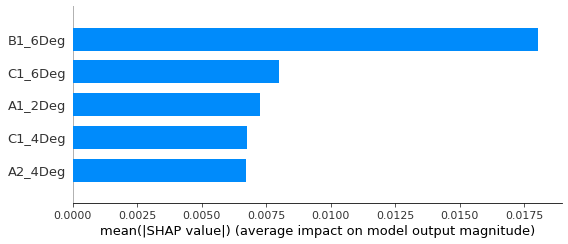

In [225]:
X_importance = X_test
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_importance)
shap.summary_plot(shap_values, X_importance,max_display=5,plot_type='bar')

In [317]:
tra_pred = rf.predict(X_train)
errors = abs(tra_pred-y_train)
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_train)

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
tra_results = ['tra',mean_squared_error(y_train,tra_pred),mean_squared_error(y_train,tra_pred,squared=False),
            mean_absolute_error(y_train,tra_pred),
            accuracy]
tra_results

['tra',
 0.002048464971864027,
 0.04525997096623049,
 0.03249034085216118,
 95.35584799678043]

In [318]:
tes_pred = rf.predict(X_test)
errors = abs(tes_pred-y_test)
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)

tes_results = ['tes',mean_squared_error(y_test,tes_pred),mean_squared_error(y_test,tes_pred,squared=False),
            mean_absolute_error(y_test,tes_pred),
            accuracy]
tes_results

['tes',
 0.027562991675775764,
 0.16602105792873315,
 0.15315921277317246,
 78.80280112133025]

In [308]:
tes_results

['tes',
 0.03565936407426949,
 0.18883687159627882,
 0.1759342812402659,
 75.91373065951235]

In [311]:
r2_score(y_test,tes_pred)

-0.2068106918607624

In [445]:
y__true = [3, -0.5, 2, 7]
y__pred = [2.5, 0.0, 2, 8]
scores = cross_val_score(lm, y__true,y__pred, scoring='r2', cv=2)
scores

array([nan, nan])

In [366]:
lm = RandomForestRegressor()
scores = cross_val_score(lm, X_train, y_train, scoring='r2', cv=5)
scores  

array([-0.58907033, -0.22020458, -0.64260745, -4.88904852,  0.10641935])

In [357]:
X_train.head(3)

,A1_1Deg,A1_1Deg_err,B1_1Deg,B1_1Deg_err,C1_1Deg,C1_1Deg_err,1_Deg_ResSoS_1,1Deg_AdjR2_1,A2_1Deg,A2_1Deg_err,...,8_Deg_ResSoS_1,8Deg_AdjR2_1,A2_8Deg,A2_8Deg_err,B2_8Deg,B2_8Deg_err,C2_8Deg,C2_8Deg_err,8_Deg_ResSoS_2,8Deg_AdjR2_2
21,-0.105797,0.438525,0.029206,0.604831,-0.631718,0.605293,0.060955,-0.255657,-0.097448,-0.390109,...,-0.359447,0.379354,0.285092,-0.328738,-0.561796,-0.354353,-0.098273,-0.354051,-0.454173,0.433839
0,-0.101457,-0.640764,-0.076286,-0.701691,0.187603,-0.701602,-0.496173,0.562528,-0.093489,-0.974860,...,-0.249948,0.388559,0.080403,-0.183744,-1.933965,-0.186078,2.430309,-0.185658,-0.346541,0.335731
26,-0.269288,-0.801428,0.535834,-0.883587,-1.112852,-0.883444,-0.534987,0.614973,0.037764,0.264921,...,-0.730132,0.757461,0.779593,-0.431261,-0.475098,-0.491390,-0.694784,-0.491384,-0.520200,0.512227


In [359]:
data_gain.head(3)

,A1_1Deg,A1_1Deg_err,B1_1Deg,B1_1Deg_err,C1_1Deg,C1_1Deg_err,1_Deg_ResSoS_1,1Deg_AdjR2_1,A2_1Deg,A2_1Deg_err,...,8Deg_AdjR2_1,A2_8Deg,A2_8Deg_err,B2_8Deg,B2_8Deg_err,C2_8Deg,C2_8Deg_err,8_Deg_ResSoS_2,8Deg_AdjR2_2,SixDegGain
0,-0.101457,-0.640764,-0.076286,-0.701691,0.187603,-0.701602,-0.496173,0.562528,-0.093489,-0.974860,...,0.388559,0.080403,-0.183744,-1.933965,-0.186078,2.430309,-0.185658,-0.346541,0.335731,0.795082
1,-0.076535,-0.561175,0.451166,-0.608657,-0.394886,-0.608655,-0.472873,0.529688,-0.269396,-0.277867,...,0.617965,2.038586,0.010963,-0.663607,-0.199878,1.178616,-0.199159,-0.203187,0.340154,0.810825
2,-0.278989,-0.744801,0.063202,-0.810950,-0.212194,-0.810821,-0.522584,0.595850,-0.239333,-1.246402,...,0.637375,-0.225273,-1.142608,-0.778159,-1.082598,0.142534,-1.083575,-0.843762,0.769440,0.776093


<BarContainer object of 1 artists>

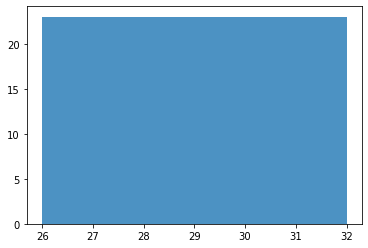

In [446]:
plt.bar(len(data_gain),train.shape[0],test.shape[0], align ='center', alpha=0.8)

In [438]:
len(data_gain)

29

In [443]:
train.shape[0]

23

In [444]:
test.shape[0]

6